In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import t
import math

season_stats = pd.read_csv('Seasons_Stats.csv')

""" Structuring a DataFrame of aspects that imply a team plays a """

# team_playing_stats = season_stats.loc['Year', 'Tm', 'MP', 'PER', 'AST', 'AST%', 'USG%', 'PTS', '3PA', '2PA', 'PF']
""" build normalized series for each interesting column """
players_df = season_stats[['Player', 'MP', 'PER', 'Tm', 'Year']].dropna()
players_df = players_df[players_df.MP > 100]    # removing players who didn't play enough
TOT_mask = players_df.Tm == 'TOT'               # the sum of stats for a player that played for more than 1 team
players_df = players_df[~TOT_mask]
players_df['TbY'] = players_df.Year.astype(int).apply(lambda name: str(name)) + ' ' + players_df.Tm

print(players_df.sort_values(by='PER', ascending=False)[['Player', 'PER', 'TbY']].head(20))

                  Player   PER       TbY
1827   Wilt Chamberlain*  31.8  1963 SFW
8869     Michael Jordan*  31.7  1988 CHI
19611       LeBron James  31.7  2009 CLE
1706   Wilt Chamberlain*  31.7  1962 PHW
21933       LeBron James  31.6  2013 MIA
1962   Wilt Chamberlain*  31.6  1964 SFW
10212    Michael Jordan*  31.6  1991 CHI
23633      Stephen Curry  31.5  2016 GSW
9747     Michael Jordan*  31.2  1990 CHI
9297     Michael Jordan*  31.1  1989 CHI
20207       LeBron James  31.1  2010 CLE
13271    David Robinson*  31.0  1997 SAS
23012      Anthony Davis  30.8  2015 NOP
11731    David Robinson*  30.7  1994 SAS
21395       LeBron James  30.7  2012 MIA
24654  Russell Westbrook  30.6  2017 OKC
14292  Shaquille O'Neal*  30.6  1999 LAL
14806  Shaquille O'Neal*  30.6  2000 LAL
19877        Dwyane Wade  30.4  2009 MIA
16286      Tracy McGrady  30.3  2003 ORL


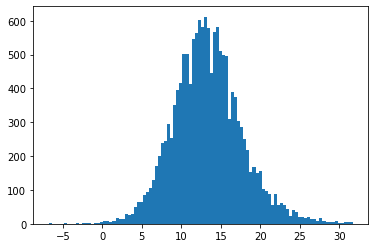

' for each TbY find most affective individual player '

In [8]:
# weights_dic = pd.Series({'FG': 85.910, 'STL': 53.897, '3P': 51.757, 'FT': 46.845, 'BLK': 39.190,
#                          'ORB': 39.190, 'AST': 34.677, 'DRB': 14.707, 'PF': -17.174, 'FT_M': -20.091,
#                          'FG_M': -39.190, 'TOV': -53.897})
#
# """ formula by https://bleacherreport.com/articles/113144-cracking-the-code-how-to-calculate-hollingers-per-without-all-the-mess"""
# approximated_PER = ((season_stats.FG * weights_dic.FG + season_stats.STL * weights_dic.STL + season_stats['3P'] * weights_dic['3P'] + \
#                    season_stats.FT * weights_dic.FT + season_stats.BLK * weights_dic.BLK + season_stats.ORB * weights_dic.ORB + \
#                    season_stats.AST * weights_dic.AST + season_stats.DRB * weights_dic.DRB + season_stats.PF * weights_dic.PF + \
#                    (season_stats.FTA - season_stats.FT) * weights_dic.FT_M + (season_stats.FGA - season_stats.FG) * weights_dic.FG_M + \
#                    season_stats.TOV * weights_dic.TOV) / season_stats.MP).dropna()
plt.hist(players_df.PER, bins=100)
plt.show()
""" for each TbY find most affective individual player """

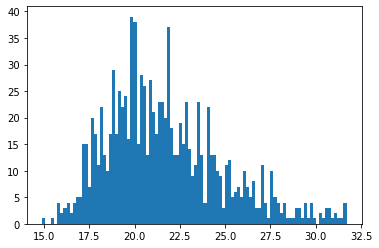

In [10]:
most_aff_player_by_team = players_df[['PER', 'TbY']].groupby(players_df.TbY).max()
plt.hist(most_aff_player_by_team.PER, bins=100)
plt.show()

In [21]:
team_records = pd.read_csv('Team_Records.csv')
# team_records = team_records[team_records.Season > '1979']

def union_star(name):
    if name.endswith('*'):
        return name[:-1]
    return name

team_records['uNAME'] = team_records.Team.apply(lambda name: union_star(name))

team_names = pd.read_csv('Team_Names.csv')

def find_team(name):
    try:
        nn = team_names[team_names.Long == name].Short
        if nn.size == 1:
            return team_names[team_names.Long == name].Short.values[0]
        return 'NOT'
    except KeyError:
        return 'NOT'

team_records['NN'] = team_records.uNAME.apply(lambda name: find_team(name))
team_records['SS'] = team_records.Season.apply(
    lambda year: year[:2] + year[-2:] if year != '1999-00' else '2000')
team_records['TbY'] = team_records.SS + ' ' + team_records.NN

trt_mask = team_records.TbY.apply(lambda ts: True if ts in most_aff_player_by_team.index else False)
team_records = team_records[trt_mask]

trr_mask = pd.Series(most_aff_player_by_team.index, index=most_aff_player_by_team.index).apply(
    lambda ts: True if ts in team_records.TbY.values else False
)
most_aff_player_by_team = most_aff_player_by_team[trr_mask]

print(team_records)

       Season   Lg                 Team   W   L   W/L%  Finish    SRS  Pace  \
1     2016-17  NBA      Boston Celtics*  53  29  0.646       1   2.25  96.8   
2     2015-16  NBA      Boston Celtics*  48  34  0.585       2   2.84  98.5   
3     2014-15  NBA      Boston Celtics*  40  42  0.488       2  -0.40  95.8   
4     2013-14  NBA       Boston Celtics  25  57  0.305       4  -4.97  93.3   
5     2012-13  NBA      Boston Celtics*  41  40  0.506       3  -0.62  91.7   
...       ...  ...                  ...  ..  ..    ...     ...    ...   ...   
1478  1999-00  NBA  Vancouver Grizzlies  22  60  0.268       7  -5.10  91.0   
1479  1998-99  NBA  Vancouver Grizzlies   8  42  0.160       7  -8.94  89.0   
1480  1997-98  NBA  Vancouver Grizzlies  19  63  0.232       6  -7.47  92.1   
1481  1996-97  NBA  Vancouver Grizzlies  14  68  0.171       7 -10.17  88.4   
1482  1995-96  NBA  Vancouver Grizzlies  15  67  0.183       7  -9.55  91.0   

      Rel_Pace  ...  Rel_ORtg   DRtg  Rel_DRtg     

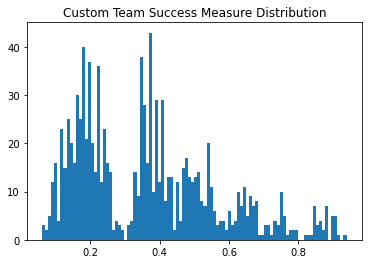

In [22]:
playoffs_weights_dic = {np.nan : 0, 'Won Finals' : 1, 'Lost Finals' : 0.8,
                        'Lost W. Conf. Finals' : 0.6, 'Lost E. Conf. Finals': 0.6,
                        'Lost W. Conf. Semis': 0.4, 'Lost E. Conf. Semis' : 0.4,
                        'Lost W. Conf. 1st Rnd.' : 0.2, 'Lost E. Conf. 1st Rnd.' : 0.2}

team_records['PW'] = team_records.Playoffs.apply(lambda score: playoffs_weights_dic[score])
success = 0.5 * team_records['W/L%'] + 0.5 * team_records.PW
success.index = team_records.TbY

plt.hist(success, bins=100)
plt.title('Custom Team Success Measure Distribution')
plt.show()

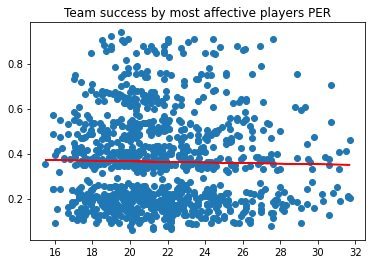

In [23]:
plt.scatter(most_aff_player_by_team.PER, success)
m, b = np.polyfit(most_aff_player_by_team.PER, success, 1)
plt.plot(most_aff_player_by_team.PER, m * most_aff_player_by_team.PER + b, color="red")
plt.title('Team success by most affective players PER')
plt.show()

In [24]:
p_value = stats.pearsonr(most_aff_player_by_team.PER, success)[0]

upper_bound = np.mean(success) - (np.std(success) / math.sqrt(len(success)) * t.ppf(0.01, len(success) - 1))
lower_bound = np.mean(success) + (np.std(success) / math.sqrt(len(success)) * t.ppf(0.01, len(success) - 1))

print(f'P_value = {p_value},   upper_bound = {upper_bound},    lower_bound = {lower_bound}')

if lower_bound < np.abs(p_value) < upper_bound:
    print('Alternative hypothesis is accepted.')
else:
    print('Alternative hypothesis is rejected.')

P_value = -0.020897440746124894,   upper_bound = 0.378257636928393,    lower_bound = 0.34909461356084415
Alternative hypothesis is rejected.
